# 05_Recurrent Neural Networks

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def mnist_load_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

# progress bar
from tqdm import tqdm_notebook

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

## 5.1 Recurrent Neurons

각 타임 스텝(time step)(또는 frame)마다 이 순환 뉴런(recurrent neuron)은 $\mathbf{x}_{t}$는 물론 이전 타임 스텝의 출력인 $y_{(t-1)}$을 입력으로 받습니다. 이 작은 네트워크를 오른쪽처럼 시간을 축으로 하여 표현할 수 있습니다. 이를 **시간에 따라 네트워크를 펼쳤다**라고 말합니다.

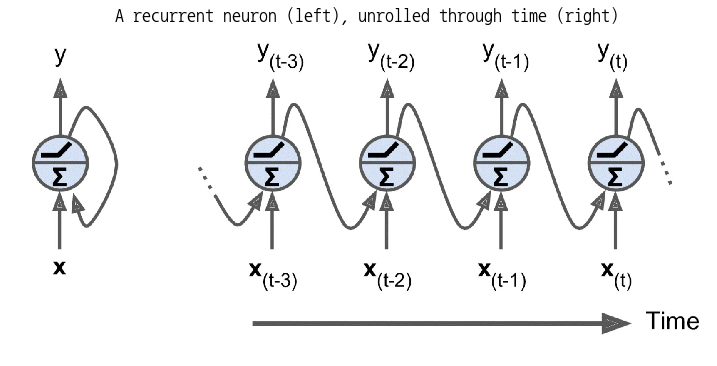

In [2]:
plt.figure(figsize=(12, 8))
plt.title("A recurrent neuron (left), unrolled through time (right)", fontsize=18)
plot_external2("./images/rnn/1.png")
plt.show()

순환 뉴런으로 된 층은 쉽게 만들 수 있습니다. 아래 그림처럼 타임 스텝 t마다 모든 뉴런은 입력 벡터 $\mathbf{x}_{(t)}$와 이전 타임 스텝의 출력 벡터 $\mathbf{y}_{(t-1)}$을 받습니다. 이제 입력과 출력이 모두 벡터가 됩니다(뉴런이 하나일 때는 출력이 스칼라입니다).

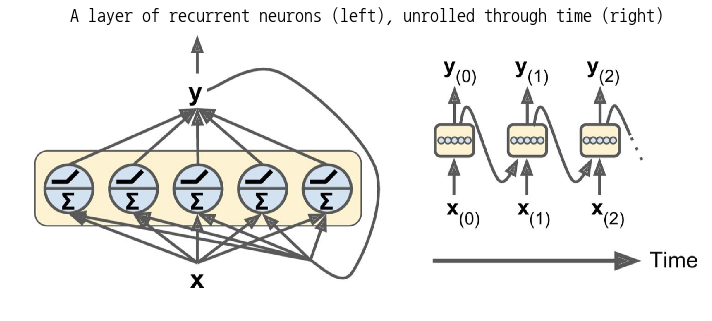

In [3]:
plt.figure(figsize=(12, 8))
plt.title("A layer of recurrent neurons (left), unrolled through time (right)", fontsize=18)
plot_external2("./images/rnn/2.png")
plt.show()

각 순환 뉴런은 두 벌의 가중치를 가집니다. 하나는 입력 $\mathbf{x}_{(t)}$를 위한 것이고 다른 하나는 이전 타임 스텝의 출력 $\mathbf{y_{(t-1)}}$을 위한 것입니다. 이 가중치 벡터를 $\mathbf{w}_{x}$와 $\mathbf{w}_y$라고 하겠습니다. 하나의 순환 뉴런이 아니라 순환 층 전체를 생각하면 가중치 벡터를 가중치 행렬 $\mathbf{W}_{x}$와 $\mathbf{W}_y$로 바꿀 수 있습니다. 그러면 순환 층 전체의 출력은 다음식과 같이 표현됩니다.

$$
    \mathbf{y}_{(t)} =\phi \left( 
{\mathbf{W}_{x}}^{T} \cdot \mathbf{x}_{(t)} + {\mathbf{W}_{y}}^{T} \cdot \mathbf{y}_{(t-1)} + \mathbf{b} 
 \right)
$$

- $\mathbf{b}$ : 편향  
- $\phi{ \left( \cdot \right)}$: 활성화함수  

타임 스텝 $t$에서의 모든 입력을 행렬 $\mathbf{X}_{(t)}$로 만들어 미니배치 전체에 대해 순환 층의 출력을 한번에 계산할 수 있습니다.  

$$
\begin{split}   
    \mathbf{Y}_{{t}} &= \phi \left( 
{\mathbf{W}_{x}}^{T} \cdot \mathbf{x}_{(t)} + {\mathbf{W}_{y}}^{T} \cdot \mathbf{y}_{(t-1)} + \mathbf{b} 
 \right)\\ 
 &= \phi\left(  
     \left[ 
         \mathbf{X}_{(t)}\mathbf{Y}_{(t-1)}
     \right]\cdot\mathbf{W} + \mathbf{b}
 \right), \qquad where\; 
 W=
 \begin{bmatrix}
     \mathbf{W}_x \\
     \mathbf{W}_y
 \end{bmatrix}
\end{split}
$$  

- $\mathbf{Y}_{(t)}$: 타임 스텝 $t$에서 미니배치에 있는 각 샘플에 대한 층의 출력을 담고 있는 $m \times n_{neurons}$행렬  
- $\mathbf{X}_{(t)}$: 모든 샘플의 입력값을 담고 있는 $m\times n_{inputs}$행렬  
- $\mathbf{W}_x$: 현재 타임 스텝의 입력에 대한 연결 가중치를 담고 있는 $n_{inputs}\times n_{neurons}$행렬  
- $\mathbf{W}_y$: 이전 타임 스텝의 출력에 대한 연결 가중치를 담고 있는 $n_{inputs} \times n_{neurons}$행렬  
- $\mathbf{b}$: 각 뉴런의 편향을 담고 있는 $n_{neurons}$크기의 벡터  
- 가중치 행렬 $\mathbf{W}_{x}$와 $\mathbf{W}_{y}$는 종종 $(n_{inputs}+n_{neurons})\times n_{neurons}$크기의 가중치 행렬 $\mathbf{W}$ 하나로 연결  
- $\left[\mathbf{X}_{(t)}\mathbf{Y}_{(t-1)}  \right]$표기는 행렬 $\mathbf{X}_{(t)}\mathbf{Y}_{(t-1)}$을 수평적으로 연결한다는 뜻  

$\mathbf{Y}_{(t)}$는 $\mathbf{X}_{(t)}$와 $\mathbf{Y}_{(t-1)}$의 함수고, $\mathbf{Y}_{(t-1)}$는 $\mathbf{X}_{(t-1)}$와 $\mathbf{Y}_{(t-2)}$의 함수고, $\mathbf{Y}_{(t-2)}$는 $\mathbf{X}_{(t-2)}$와 $\mathbf{Y}_{(t-3)}$의 함수가 되는 식입니다. 결국 $\mathbf{Y}_{(t)}$는 시간 $t=0$에서부터 모든 입력에 대한 함수가 됩니다(즉, $\mathbf{X}_{0},\,\mathbf{X}_{1},\,\cdots ,\, \mathbf{X}_{t}$). 첫 번째 타임 스텝 $t=0$에서는 이전 출력이 없으므로 보통 모두 0이라고 가정합니다.  

<br><br>

### 5.1.1 Memory Cells  
타임 스텝 $t$에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이기 때문에 이를 일종의 **메모리(memory)** 형태라고 말할 수 있습니다. 타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소를 **메모리 셀(memory cell)**혹은 간단히 **셀**이라고 합니다. 하나의 순환 뉴런 또는 순환 뉴런의 층은 매우 **기본적인 셀**입니다. 하지만 이 장 뒷부분에서 더 복잡하고 강력한 종류의 셀을 볼 것입니다.  

일반적으로 타임 스텝 $t$에서의 셀의 상태 $\mathbf{h}_{t}$는 그 타임 스텝의 입력과 이전 타임 스텝의 상태에 대한 함수입니다. 즉 $\mathbf{h}_{(t)} = f(\mathbf{h_{(t-1)}},\, \mathbf{x}_{(t)})$입니다. 타임 스텝 $t$에서의 출력 $\mathbf{y}_{(t)}$도 이전 상태와 현재 입력에 대한 함수입니다. 

### 5.1.2 Input and Output Sequences

RNN은 입력 시퀀스를 받아 출력 시퀀스를 만들 수 있습니다. 

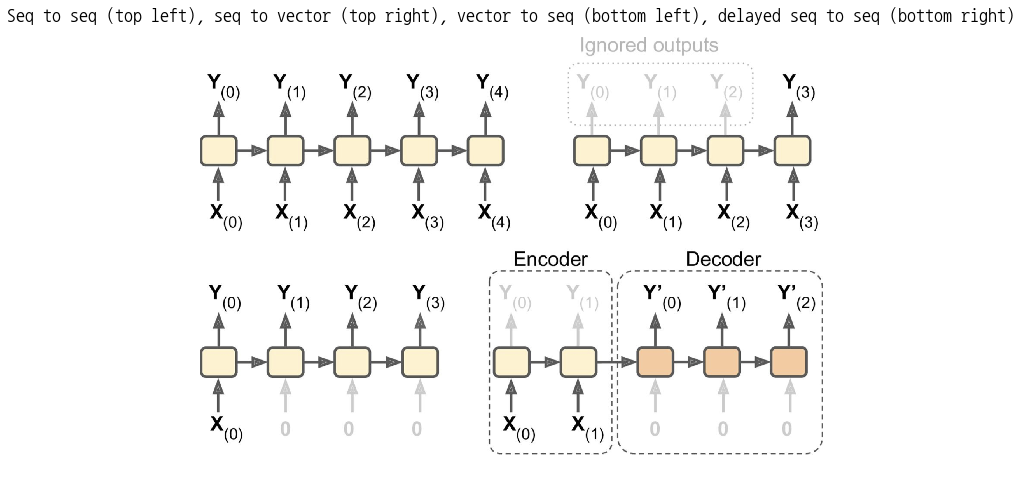

In [4]:
plt.figure(figsize=(12, 8))
plt.title("Seq to seq (top left), seq to vector (top right), vector to seq (bottom left), delayed seq to seq (bottom right)", fontsize=18)
plot_external2("./images/rnn/3.png")
plt.show()

위 그림(왼쪽 위)는 시퀀스-투-시퀀스(sequence-to-sequence)네트워크로, 예를 들어 주식가격 같은 시계열 데이터를 예측하는 데 유용합니다. 최근 N일치의 주식가격을 주입하면 네트워크는 하루 앞선 가격을 출력해야 합니다(즉, N-1일 전부터 내일까지).  

또는 입력 시퀀스를 네트워크에 주입하고, 마지막을 제외한 모든 출력을 무시할 수 있습니다(오른쪽 위의 네트워크). 이는 시퀀스-투-벡터(sequence-to-vector) 네트워크로, 예를 들어 영화 리뷰에 있는 연는 연속된 단어를 주입하면 네트워크는 감성 점수를 출력합니다(예를 들면 -1(싫다)에서부터 +1(좋다)까지).  

반대로 첫 번째 타임 스텝에서 단 하나의 입력만(다른 모든 타임 스텝에서는 0을) 네트워크에 주입하고, 출력 시퀀스를 연결할 수 있습니다(왼쪽 아래 네트워크). 이는 벡터-투-시퀀스(vector-to-sequence) 네트워크로, 예를 들어 이미지를 입력하여 이미지에 대한 캡션을 출력할 수 있습니다.  

또한 **인코더(encoder)**라 불리는 시퀀스-투-벡터 네트워크 뒤에 디코더(decoder)라 불리는 벡터-투-시퀀스 네트워크를 연결할 수 있습니다(오른쪽 아래 네트워크). 이는 지연된 시퀀스-투-시퀀스(delayed sequence-to-sequence) 네트워크로, 예를 들어 한 언어의 문장을 다른 언어로 번역하는 데 사용할 수 있습니다. 한 언어의 문장을 네트워크에 주입하면 인코더는 이 문장을 하나의 벡터표현으로 변환하고, 그 다음에 디코더가 이 벡터를 다른 언어의 문장으로 디코딩합니다. 인코더-디코더로 불리는 이런 이중 단계 모델은 하나의 시퀀스-투-시퀀스 RNN을 사용하여 한 단어씩 번역하는 것보다 훨씬 더 잘 작동합니다. 문장의 마지막 단어가 번역의 첫번째 단어에 영향을 줄 수 있기 때문입니다. 그래서 번역하기 전에 전체 문장이 주입될 때까지 기다릴 필요가 있습니다.

<br>
<br>

### 5.2 Basic RNNs in TensorFlow
내부 구조를 잘 이해하기 위해 먼저 텐서플로의 RNN 연산을 전혀 사용하지 않고 매우 간단한 RNN 모델을 구현해보겠습니다. tanh 활성화 함수를 사용하여 다섯 개의 순환 뉴런의 층으로 구성된 RNN을 만들겠습니다. 이 RNN은 타임 스텝마다 크기 3의 입력 베터를 받고 단지 2개의 타임 스텝에 대해서만 작동한다고 가정하겠습니다.

In [5]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


이 네트워크는 같은 가중치와 편향을 양쪽 층이 공유한다는 점과 층마다 입력을 주입하고 출력을 얻는다는 점을 빼면 2개의 층이 있는 신경망과 매우 비슷합니다. 이 모델을 실행하려면 두 타임 스텝에 입력을 다음과 같이 주입해야 합니다.

In [6]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [7]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [8]:
print(Y1_val)

[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


<br>
<br>

### 5.2.1 Static Unrolling Through Time 

In [9]:
n_inputs = 3
n_neurons = 5

`static_rnn()`함수는 셀을 연결하여 펼쳐진 RNN 네트워크를 만듭니다. 다음 코드는 이전에 만든 것과 정확히 동일한 모델을 생성합니다.  

In [10]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


플레이스홀더를 만든 후 그런 다음 (타임 스텝마다 하나씩) 펼쳐진 RNN을 만들기 위해 셀의 복사본을 만드는 factory로 생각할 수 있는 BasicRNNCell 객체를 만듭니다. 그런 다음 static_rnn() 함수를 호출해서 셀과 입력 텐서를 전달하고, 입력의 데이터 타입을 알려줍니다(기본적으로 모두 0으로 채워지는 초기 상태 행렬을 만들기 위해). `static_rnn()` 함수는 입력마다 셀의 `__call__()` 함수를 호출하여 가중치와 편향을 공유한 셀 복사본 2개를 만들고(각각 다섯 개의 순환 뉴런으로 된 층을 포함) 이전에 했던 것처럼 서로 연결합니다. `static_rnn()`함수는 2개의 객체를 리턴합니다. 첫 번째는 각 타임 스텝에서의 출력 텐서를 담고 있는 파이썬 리스트입니다. 2번째는 네트워크의 최종 상태를 담고 있는 텐서입니다. 기본적인 셀을 사용할 때는 최종 상태가 마지막 출력과 동일합니다.  

In [11]:
init = tf.global_variables_initializer()

In [12]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [13]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542541 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [14]:
Y1_val

array([[ 0.99998885, -0.99976057, -0.0667929 , -0.9999803 ,  0.99982214],
       [-0.6524943 , -0.51520866, -0.37968948, -0.5922594 , -0.08968379],
       [ 0.99862397, -0.99715203, -0.03308626, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307606 ,  0.79671973]],
      dtype=float32)

In [15]:
from tensorflow_graph_in_jupyter import show_graph

In [16]:
show_graph(tf.get_default_graph())

#### 5.2.1.1 sequence padding

만약 50개의 타임 스텝이 있다면 50개의 입력 플레이스홀더와 50개의 출력 텐서를 정의하는건 번거로운 일입니다. 게다가 실행할 때 50개의 플레이스홀더에 데이터를 주입하고 50개의 출력을 받아야 합니다. 예를 들어보면 첫번째 차원의 크기가 [None, n_steps, n_inputs]크기의 입력 플레이스홀더를 만듭니다. 그리고 각 타임 스텝에 대한 입력 리스트를 만듭니다. X_seq는 n_steps 개 텐서를 가진 파이썬 리스트입니다. 이 텐서는 [None, n_inputs] 크기이고 첫 번째 차원은 미니 배치 크기입니다. 이렇게 하기 위해 `transpose()` 함수를 사용해 첫 2 차원을 바꾸어 타임 스텝이 첫 번째 차원이 되었습니다. 그런 다음 `unstack()` 함수를 사용해 첫 번째 차원을 따라 텐서의 파이썬 리스트를 추출합니다(즉, 타임스텝마다 하나의 텐서). 다음 2줄은 이전과 동일합니다. 마지막으로 `stack()` 함수를 사용해 모든 출력 텐서를 하나의 텐서로 합칩니다. 그리고 첫 2차원을 바꾸어 [None, n_steps, n_neurons] 크기의 최종 outputs 텐서를 만듭니다

In [17]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [18]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [19]:
init = tf.global_variables_initializer()

In [20]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # 샘플 1
        [[3, 4, 5], [0, 0, 0]], # 샘플 2
        [[6, 7, 8], [6, 5, 4]], # 샘플 3
        [[9, 0, 1], [3, 2, 1]], # 샘플 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [21]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]]


In [22]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]
 [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]
 [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]
 [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]


이 방법은 타임 스텝마다 하나의 셀을 그래프에 추가합니다. 만약 50개 타임 스텝이라면 이 그래프는 매우 복잡합니다. 이는 반복문을 사용하지 않고 프로그래을 만드는 것과 같습니다. 아주 큰 그래프라면 역전파하는 동안 ***out-of-memory***(메모리부족) 에러가 발생할 수도 있습니다. 이를 해결하기 위하여 tensorflow에서는 `dynamic_rnn()`함수가 있습니다.

<br>
<br>

### 5.2.2 Dynamic Unrolling Through Time

`dynamic_rnn()`함수는 적절한 타임 스텝에 걸쳐 셀을 실행하기 위해 `while_loop()`연산을 사용합니다. 그리고 GPU 메모리에서 CPU 메모리로 바꾸어 역전파 시에 OOM 에러를 피하고 싶다면 `swap_memory=True`옵션을 설정합니다. 이 함수는 편리하게도 각 타임 스텝의 모든 입력에 대해 텐서 하나를 받고 ([None, n_steps, n_inputs] 크기), 타임 스텝마다의 모든 출력을 하나의 텐서로 ([None, n_steps, n_neurons] 크기) 반환합니다. 즉 `stack()`, `unstack()`, `transpose()` 함수를 사용할 필요가 없습니다. 다음 코드는 dynamic_rnn() 함수를 사용하여 이전과 동일한 RNN을 만듭니다. 

In [23]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [24]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [25]:
init = tf.global_variables_initializer()

In [26]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [27]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.999996    0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.85227895  0.5845349  -0.78780943]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624866   0.99817705  0.80142   ]]]


In [28]:
show_graph(tf.get_default_graph())

<br>
<br>

### 5.2.3 Handling Variable Length Input Sequences

만약 각 시퀀스의 길이를 미리 알 수 있다면(예를 들어 입력 시퀀스와 동일한 길이가 될 것이라고 알고 있다면) `sequence_length`매개변수를 지정할 수 있습니다. 일반적으로 이는 불가능합니다. 예를들어 번역된 문장의 길이는 보통 입력 문장의 길이와 다릅니다. 이런 경우 일반적인 해결책은 **EOS Token(End-of-sequence token)이라 불리는 특별한 출력을 정의하는 것입니다.** EOS보다 큰 출력은 모두 무시됩니다.  

In [29]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [30]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

Instructions for updating:
Use tf.cast instead.


In [31]:
init = tf.global_variables_initializer()

In [32]:
X_batch = np.array([
        # 스텝 0     스텝 1
        [[0, 1, 2], [9, 8, 7]], # 샘플 1
        [[3, 4, 5], [0, 0, 0]], # 샘플 2 (0 벡터로 패딩)
        [[6, 7, 8], [6, 5, 4]], # 샘플 3
        [[9, 0, 1], [3, 2, 1]], # 샘플 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [33]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [34]:
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.956726    0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [35]:
print(states_val)

[[-1.          0.956726    0.99831694  0.99970174  0.96518576]
 [-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]
 [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]


## 5.3 Training RNNs

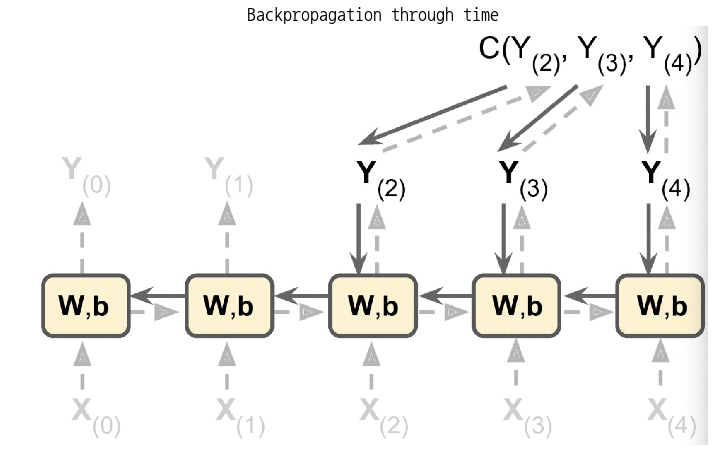

In [36]:
plt.figure(figsize=(12, 8))
plt.title("Backpropagation through time", fontsize=18)
plot_external2("./images/rnn/4.png")
plt.show()

RNN을 훈련시키기 위한 기법은 타임 스텝으로 네트워크를 펼치고 보통의 역전파를 사용하는 것입니다. 이런 전략을 **BPTT(BackPropagation Through Time)**라고 합니다.  

보통의 역전파와 같이 첫 번째 정방향 패스가 펼쳐진 네트워크를 통과합니다(점선화살). 그러면 비용 함수 C($\mathbf{Y}_{(t_{min})},\, \mathbf{Y}_{(t_{min+1})},\, \cdots,\, \mathbf{Y}_{(t_{max})}$)를 사용하여 출력 시퀀스가 평가됩니다. ($t_{min}$과 $t_max$는 첫 번째와 마지막 출력 타임 스텝이며 무시된 출력은 카운팅하지 않습니다). 그리고 비용 함수의 그래디언트는 펼쳐진 네트워크를 따라 역방향으로 전파됩니다(실선화살). 결국 모델 파라미터는 BPTT 동안 계산된 그래디언트를 사용하여 업데이트 됩니다. 그래디언트가 마지막 출력뿐만 아니라 비용함수를 사용한 모든 출력에서 역방향으로 전파됩니다(예를 들어 위 그림에서 네트워크의 마지막 세 개의 출력$\mathbf{Y}_{(2)},\, \mathbf{Y}_{(3)},\, \mathbf{Y}_{(4)}$를 사용하여 비용 함수가 계산됩니다. 따라서 그래디언트는 이 세 개의 출력을 거쳐 흐르지만 $\mathbf{Y}_{0}$과 $\mathbf{Y}_{1}$은 거치지 않습니다.) 
순환 신경망은 일련의 타임스텝을 진행하고 나서 그래디언트가 전파됩니다. 즉 정방향 패스 동안에는 모두 일정한 가중치가 적용됩니다. 따라서 각 타임 스텝마다 같은 매개변수 $\mathbf{W}$와 $\mathbf{b}$가 사용되기 때문에 역전파가 진행되면 모든 타임 스텝에 걸쳐 합산됩니다.

<br>
<br>

### 5.3.1 Training a Sequence Classifier

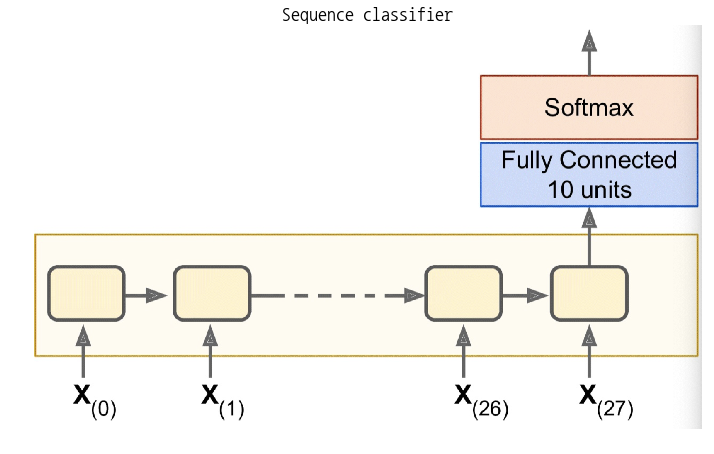

In [37]:
plt.figure(figsize=(12, 8))
plt.title("Sequence classifier", fontsize=18)
plot_external2("./images/rnn/5.png")
plt.show()

**MNIST** 이미지를 분류하는 ***RNN***을 위 그림처럼 구성해보겠습니다. 이미지 분류에 ***RNN***을 사용할 수 있습니다. 여기에서는 이미지를 각각 28개 픽셀을 가진 28개 행의 시퀀스로 생각하겠습니다(MNIST 이미지가 28x28 이므로). 150개의 순환 뉴런으로 된 셀을 사용하고, 마지막 타임 스텝의 출력에 10개 뉴런으로된 완전 연결망을 연결하고, 소프트맥스 층을 마지막에 연결하였습니다.

In [38]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

Instructions for updating:
Use keras.layers.dense instead.


완전 연결 층이 RNN의 마지막 상태만 담고 있는 states 텐서에 연결되어 있습니다. 그리고 y는 타겟 클래스를 위한 플레이스 홀더입니다.

In [39]:
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [40]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = mnist_load_data()

In [41]:
X_test = X_test.reshape((-1, n_steps, n_inputs))
X_valid = X_valid.reshape((-1, n_steps, n_inputs))

In [42]:
n_epochs = 100
batch_size = 150
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X:X_batch, y:y_batch})
        val_loss, val_acc = sess.run([loss, accuracy], feed_dict={X:X_valid, y:y_valid})
        
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        if (epoch+1) % 20 ==0:        
            print(f"epoch: {epoch+1}")
            print(f"배치 데이터 정확도: {train_acc}")
            print(f"검증 세트 정확도: {val_acc}\n")

epoch: 20
배치 데이터 정확도: 0.9800000190734863
검증 세트 정확도: 0.9782000184059143

epoch: 40
배치 데이터 정확도: 0.9866666793823242
검증 세트 정확도: 0.9769999980926514

epoch: 60
배치 데이터 정확도: 0.9933333396911621
검증 세트 정확도: 0.9810000061988831

epoch: 80
배치 데이터 정확도: 0.9933333396911621
검증 세트 정확도: 0.9801999926567078

epoch: 100
배치 데이터 정확도: 0.9933333396911621
검증 세트 정확도: 0.980400025844574



In [43]:
train_acc_ = history["train_acc"]
train_loss_ = history["train_loss"]
val_acc_ = history["val_acc"]
val_loss_ = history["val_loss"]

In [44]:
len(val_loss_)

100

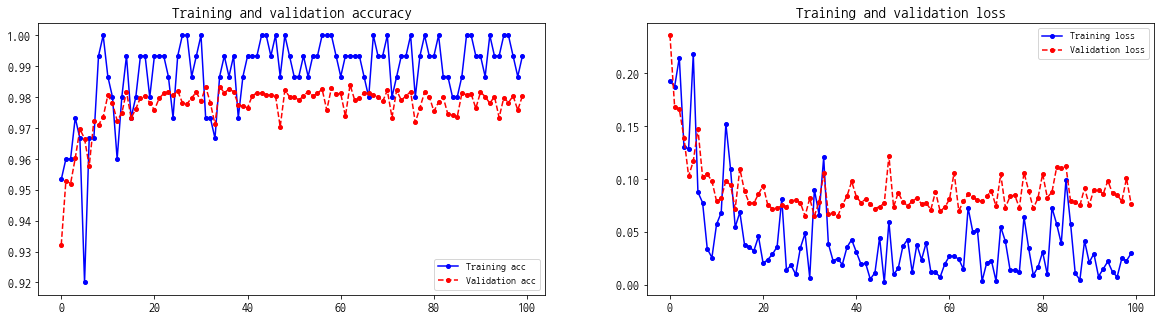

In [45]:
epochs = range(n_epochs)
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(epochs, train_acc_, "bo-", markersize =4, label="Training acc")
plt.plot(epochs, val_acc_, "ro--", markersize = 4, label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.subplot(122)
plt.plot(epochs, train_loss_, 
         marker="o", linestyle="-", 
         color="b", label="Training loss", 
         markersize=4)
plt.plot(epochs, val_loss_, 
         color="r", linestyle="--", 
         marker="o", markersize=4, 
         label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

<br>
<br>

## 5.4 Time series

인공적으로 생성한 시계열 데이터의 다음 값을 예측하는 RNN을 만들어보겠습니다. 각 훈련 샘플을 시계열 데이터에서 연속된 20개의 값을 랜덤하게 선택한 값입니다. 타겟 시퀀스는 타임 스텝 하나만큼 앞으로 이동한 것을 제외하고는 입력 시퀀스와 동일합니다.

In [22]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

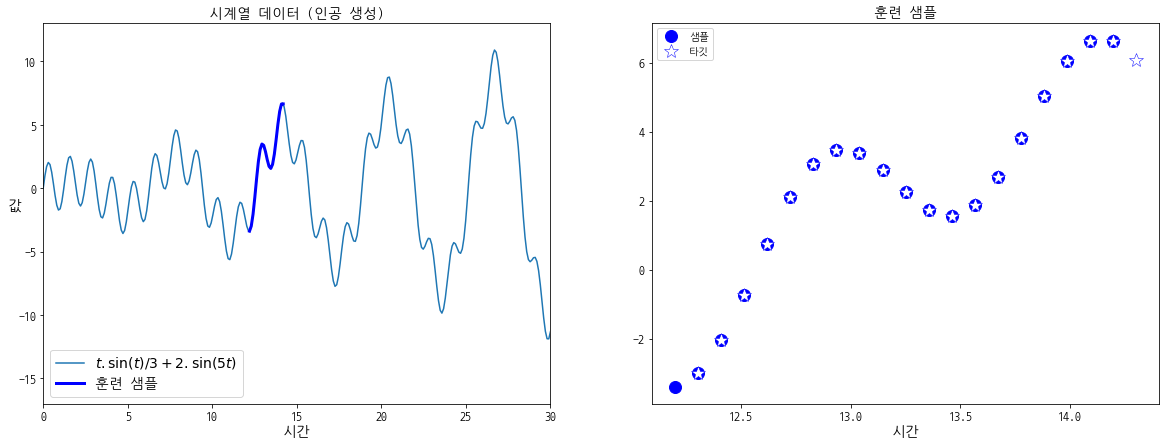

In [47]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(20,7))
plt.subplot(121)
plt.title("시계열 데이터 (인공 생성)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="훈련 샘플")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("시간")
plt.ylabel("값", rotation=0)

plt.subplot(122)
plt.title("훈련 샘플", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="샘플")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="타깃")
plt.legend(loc="upper left")
plt.xlabel("시간")

plt.show()

### 5.4.1 `OuputProjectionWrapper` 사용하기

RNN 하나를 만들어 보겠습니다. 이 신경망은 100개의 순환 뉴런을 가지고 있고 각 훈련 샘플은 20개의 입력 길이로 구성되므로 20개의 타임 스텝에 펼칠 것입니다. 각 입력은 하나의 특성을 가집니다(각 시간에서의 값 하나). 타깃도 20개의 입력 시퀀스이고 하나의 값을 가집니다:

In [48]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

일반적으로 특성이 하나 이상일 경우가 많습니다. 예를 들어 주식가격을 예측한다면 타임 스텝마다 경쟁사 주식가격, 애널리스트 평가치 같은 입력 특성이나 예측에 도움이 될 만한 다른 어떤 특성이 있을 수 있습니다.

각 타임 스텝에서 뉴런의 갯수(n_neurons)가 100이므로 출력의 크기가 100인 출력 벡터가 만들어 집니다. 하지만 실제로 원하는 것은 타임 스텝마다 하나의 출력입니다. 이럴 때 사용하는 간단한 방법은 `OutputProjectionWrapper`로 셀을 감싸는 것입니다. 셀 wrapper는 보통의 셀과 매우 비슷하게 작동하며 모든 메서드 호출을 감싼 셀로 전달합니다. 하지만 몇 가지 기능도 더 있습니다. `OutputProjectionWrapper`는 각 출력의 상단에 선형 뉴런으로 구성된 완전 연결 층을(즉, 어떤 활성화 함수 없이) 추가합니다(셀 래퍼의 완전 연결 층은 outputs에만 적용되고 stats에는 적용되지 않기 때문에 셀 상태에는 영향을 주지 않습니다). 이 완전 연결 층은 동일한 (훈련할 수 있는) 가중치와 편향을 공유합니다. 최종적으로 만들어진 RNN은 아래와 같습니다.

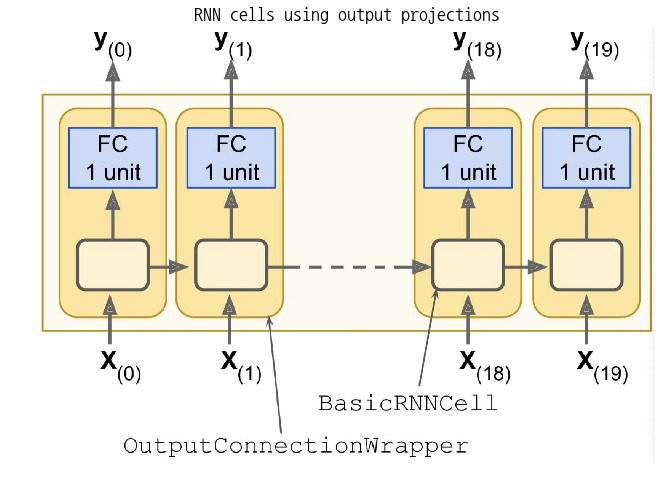

In [49]:
plt.figure(figsize=(12, 8))
plt.title("RNN cells using output projections", fontsize=18)
plot_external2("./images/rnn/6.png")
plt.show()

셀 wrapper의 사용은 다음처럼 사용합니다.  

```python
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=100, activation=tf.nn.relu),
    output_size=1)
```

> Using an **OuputProjectionWrapper**

In [50]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [51]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [52]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [53]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [54]:
saver = tf.train.Saver()

In [55]:
n_iterations = 1500
batch_size = 50
history = {"train_loss": []}
n_epochs = n_iterations // batch_size # 30

with tf.Session() as sess:
    init.run()
    for iteration in range(n_epochs):
        for i in range(batch_size):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if (iteration+1) %  5 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(f"{iteration+1}", "\tMSE:", mse)
        train_loss = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
        
        history["train_loss"].append(train_loss) 
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
    saver.save(sess, "./models/05_rnn/outputprojectionwrapper/my_time_series_model")

5 	MSE: 0.0759212
10 	MSE: 0.050135083
15 	MSE: 0.053096972
20 	MSE: 0.04536663
25 	MSE: 0.048508085
30 	MSE: 0.04479627


In [56]:
train_loss_ = history["train_loss"]

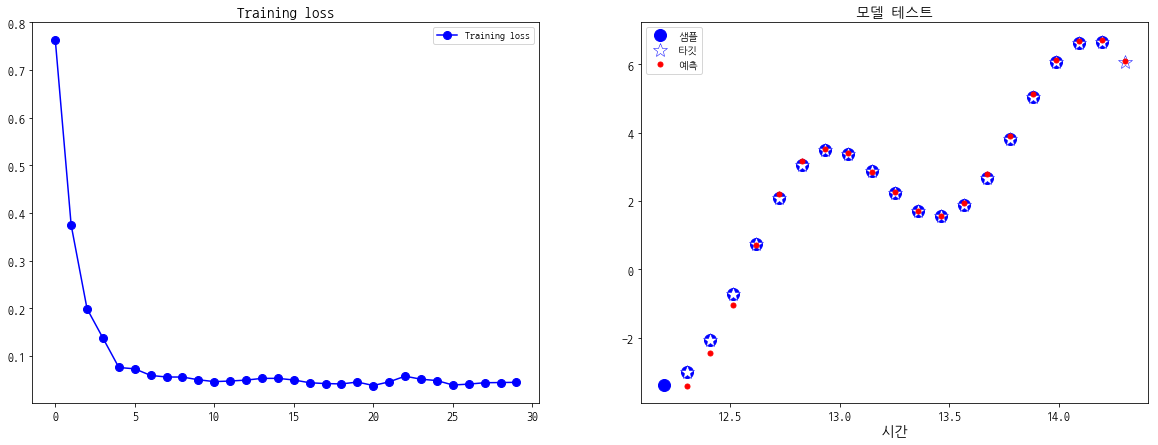

In [57]:
epochs = range(n_epochs)
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.plot(epochs, train_loss_, 
         marker="o", linestyle="-", 
         color="b", label="Training loss", 
         markersize=8)
plt.title("Training loss")
plt.legend()

plt.subplot(122)
plt.title("모델 테스트", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="샘플")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="타깃")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="예측")
plt.legend(loc="upper left")
plt.xlabel("시간")

plt.show()

### 5.4.2 `OuputProjectionWrapper` 사용하지 않기

`OutputProjectionWrapper()`를 사용하는 것이 **RNN**의 출력 시퀀스 차원을 타임 스텝마다(그리고 샘플마다) 하나의 값으로 줄이는([50, 20, 100] -> [50, 20, 1])가장 간단한 솔루션이지만, 아주 효율적이지는 않습니다. 더 효율적으로 바꾸려면 **RNN**의 출력을 [batch_size, n_steps, n_neurons] -> [batch_size * n_steps, n_neurons]로 바꾸고, 출력 크기(여기서는 1)에 맞게 단일 완전 연결 층을 적용하여 출력 텐서의 크기를 [batch_size * n_steps, n_neurons]로 만들고 그다음에 이 텐서의 크기를 [batch_size, n_steps, n_neurons]으로 바꿉니다([50, 20, 100]크기의 출력을 [1000, 100]으로 바꾸고, 완전 연결층을 지나면서 [1000, 100] -> [1000, 1] -> [50, 20, 1]로 바꿉니다).  

이 과정은 아래 그림과 같습니다.

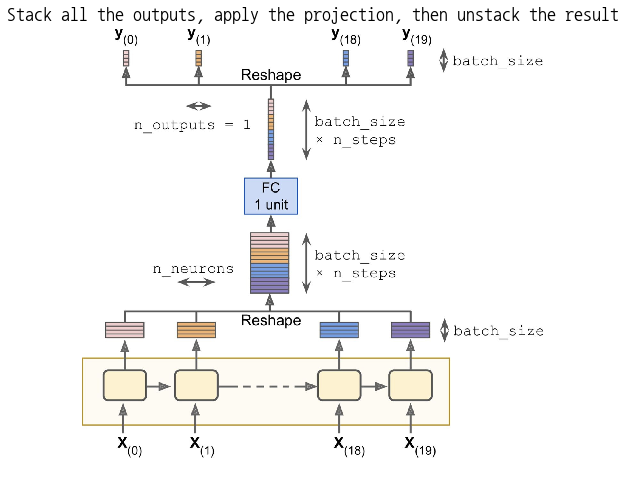

In [4]:
plt.figure(figsize=(12, 8))
plt.title("Stack all the outputs, apply the projection, then unstack the result", fontsize=18)
plot_external2("./images/rnn/7.png")
plt.show()

이 방식을 적용해보겠습니다.

> `OutputProjectionWrapper` 사용하지 않기

In [23]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [24]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [25]:
n_outputs = 1
learning_rate = 0.001

In [26]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

`reshape()`연산을 사용해 모든 출력을 차례대로 쌓고, 완전 연결 선형 층을 적용하고(어떤 활성화 함수도 사용하지 않습니다. 단지 차원만 축소시킵니다), 마지막으로 `reshape()`연산을 사용해 모든 출력을 원래 차원으로 되돌립니다.  
이 코드는 타임 스텝마다 완전 연결층을 만들지 않고 하나의 완전 연결 층만 만들기 때문에 속도가 훨씬 빠릅니다.

In [27]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [28]:
n_iterations = 1500
batch_size = 50
n_epochs = n_iterations // batch_size ## 30
history = {"train_loss": []}

In [29]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)
with tf.Session() as sess:
    init.run()
    for iteration in range(n_epochs):
        for i in range(batch_size):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        if (iteration+1) % 6 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(f"epochs: {iteration+1}", "\tMSE:", mse)
            
        train_loss = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
        history["train_loss"].append(train_loss)
            
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./models/05_rnn/without_outputprojectionwrapper/my_time_series_model")

epochs: 6 	MSE: 0.11104397
epochs: 12 	MSE: 0.04806255
epochs: 18 	MSE: 0.043414045
epochs: 24 	MSE: 0.051778547
epochs: 30 	MSE: 0.043919496


In [30]:
train_loss_ = history["train_loss"]

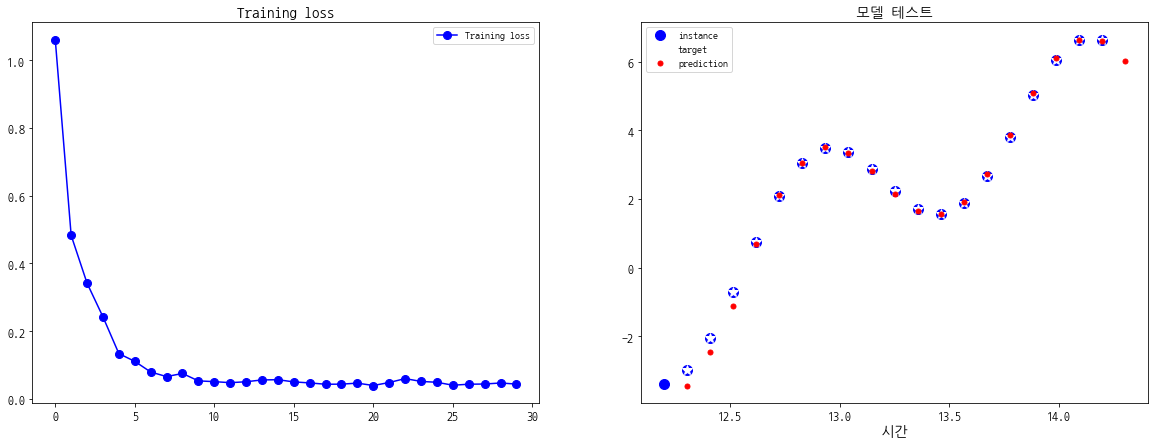

In [31]:
epochs = range(n_epochs)
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.plot(epochs, train_loss_, 
         marker="o", linestyle="-", 
         color="b", label="Training loss", 
         markersize=8)
plt.title("Training loss")
plt.legend()

plt.subplot(122)
plt.title("모델 테스트", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("시간")

plt.show()

### Creative RNN

In [32]:
[v.name for v in tf.global_variables()]

['rnn/basic_rnn_cell/kernel:0',
 'rnn/basic_rnn_cell/bias:0',
 'dense/kernel:0',
 'dense/bias:0',
 'beta1_power:0',
 'beta2_power:0',
 'rnn/basic_rnn_cell/kernel/Adam:0',
 'rnn/basic_rnn_cell/kernel/Adam_1:0',
 'rnn/basic_rnn_cell/bias/Adam:0',
 'rnn/basic_rnn_cell/bias/Adam_1:0',
 'dense/kernel/Adam:0',
 'dense/kernel/Adam_1:0',
 'dense/bias/Adam:0',
 'dense/bias/Adam_1:0']

In [33]:
with tf.Session() as sess:
    saver.restore(sess, "./models/05_rnn/without_outputprojectionwrapper/my_time_series_model")
    sequence = [0.] * n_steps

    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./models/05_rnn/without_outputprojectionwrapper/my_time_series_model


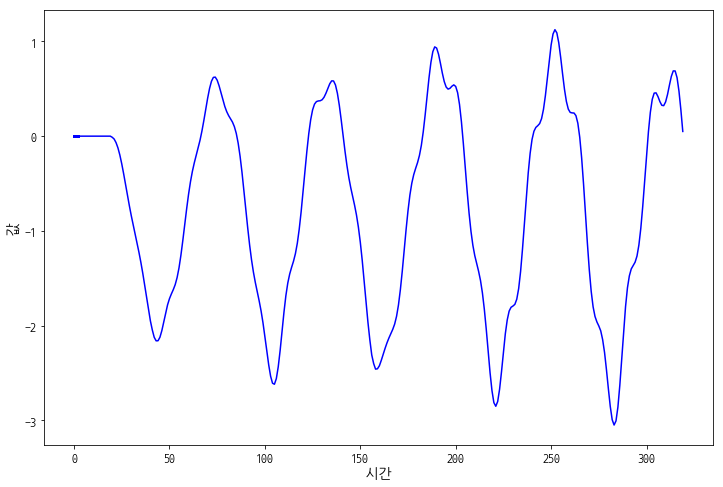

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("시간")
plt.ylabel("값")
plt.show()

In [37]:
with tf.Session() as sess:
    saver.restore(sess, "./models/05_rnn/without_outputprojectionwrapper/my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

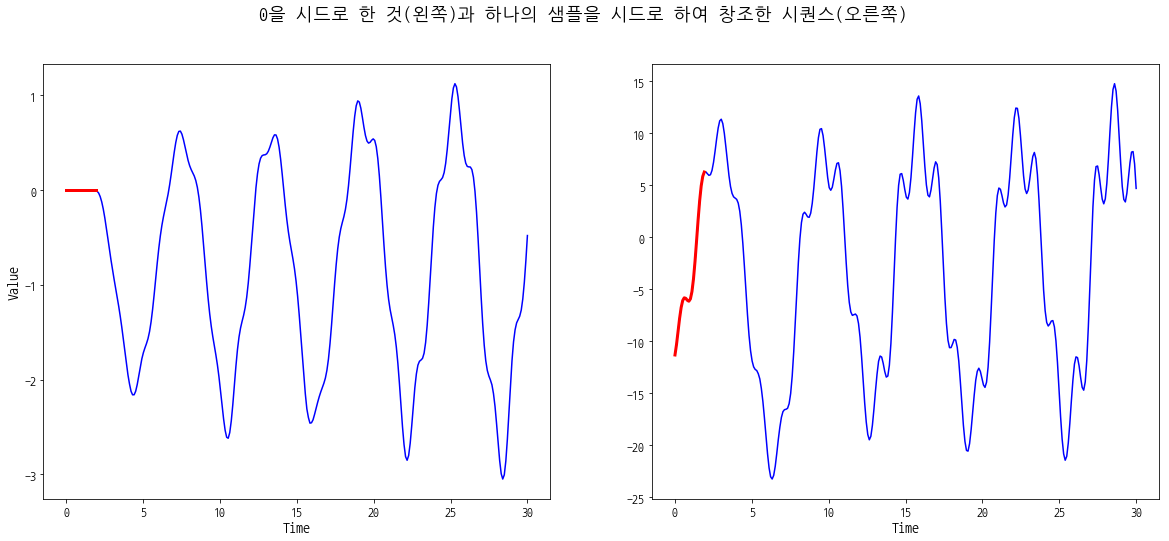

In [39]:
plt.figure(figsize=(20, 8)).suptitle("0을 시드로 한 것(왼쪽)과 하나의 샘플을 시드로 하여 창조한 시퀀스(오른쪽)", fontsize=18)
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], linestyle="-", color="r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], linestyle="-", color="r", linewidth=3)
plt.xlabel("Time")

plt.show()

<br>
<br>

## Deep RNNs

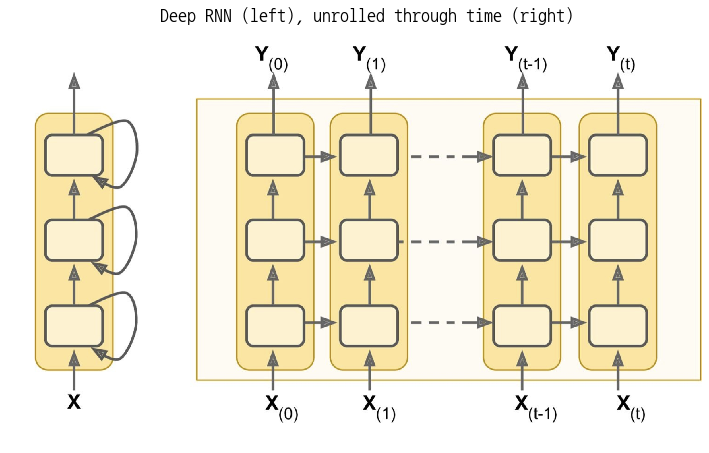

In [40]:
plt.figure(figsize=(12, 8))
plt.title("Deep RNN (left), unrolled through time (right)", fontsize=18)
plot_external2("./images/rnn/8.png")
plt.show()

위 그림에서 볼 수 있듯이 셀을 여러 층으로 쌓는 것은 상당히 일반적이며, 이를 deep RNN이라고 합니다. 심층 RNN을 텐서플로로 구현하려면 여러 개의 셀을 마늘어 **MultiRNNCell**로 쌓아올립니다. 

In [41]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [42]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [43]:
init = tf.global_variables_initializer()

In [44]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [45]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [46]:
outputs_val.shape

(2, 5, 100)

### Dropout

매우 깊은 RNN을 만들면 훈련 세트에 과대적합되기 쉽습니다. 이를 막기 위한 일반적인 방법은 드롭아웃을 적용하는 것입니다. 이전에 했던 것처럼 **RNN**의 전후에 드롭아웃층을 추가할 수 있습니다. RNN 층 사이에도 드롭아웃을 적용하려면 DropoutWrapper 클래스를 사용하면 됩니다. 

In [47]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [48]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

노트: `input_keep_prob` 매개변수는 플레이스홀더로 훈련하는 동안에는 어느 값이나 가능하고 테스트할 때는 1.0으로 지정합니다(드롭아웃을 끕니다).

In [49]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [50]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [68]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5
n_batchs = n_iterations // batch_size

history = {"train_loss": []}

dir_path = "./models/05_rnn/5_Deep_RNNs/Dropout"
if not os.path.isdir(dir_path):
    os.makedirs(dir_path)

> training

In [69]:
save_model_path = os.path.join(dir_path, "my_dropout_time_series_model")
with tf.Session() as sess:
    init.run()
    for iteration in range(n_batchs):
        for i in range(batch_size):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            _, mse = sess.run([training_op, loss],
                              feed_dict={X: X_batch, y: y_batch,
                                         keep_prob: train_keep_prob})

        history["train_loss"].append(mse)
        if (iteration+1) % 5 == 0:                   
            print(f"epochs: {iteration+1}", f"train MSE: {mse}")
    
    saver.save(sess, save_model_path)

epochs: 5 train MSE: 4.559531211853027
epochs: 10 train MSE: 3.2204813957214355
epochs: 15 train MSE: 3.4565165042877197
epochs: 20 train MSE: 2.956509828567505
epochs: 25 train MSE: 3.0164618492126465
epochs: 30 train MSE: 3.347282886505127


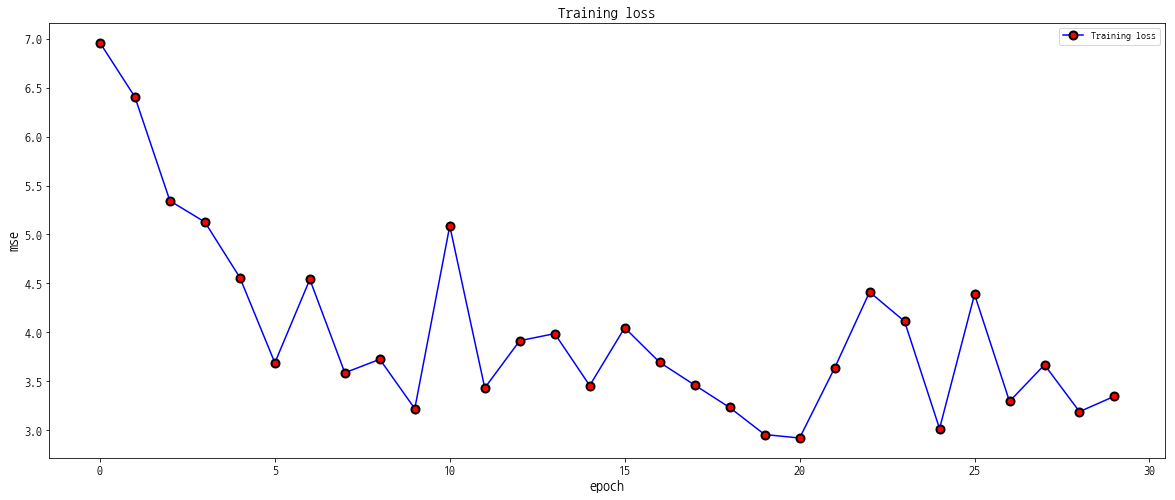

In [82]:
train_loss_ = history["train_loss"]
epochs = range(len(train_loss_))
plt.figure(figsize=(20, 8))
plt.subplot(111)
plt.plot(epochs, train_loss_, 
         marker="o", linestyle="-", 
         color="b", label="Training loss", 
         markersize=8, markeredgecolor="k", markerfacecolor="r", markeredgewidth=2)
plt.title("Training loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.show()

> test

테스트할 때는 **반드시 keep_prob**를 기본값 1이 되도록 두어 드롭아웃을 꺼내야 합니다(드롭아웃은 훈련하는 동안에만 활성화되어야 합니다).

In [83]:
with tf.Session() as sess:
    saver.restore(sess, save_model_path)

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./models/05_rnn/5_Deep_RNNs/Dropout/my_dropout_time_series_model


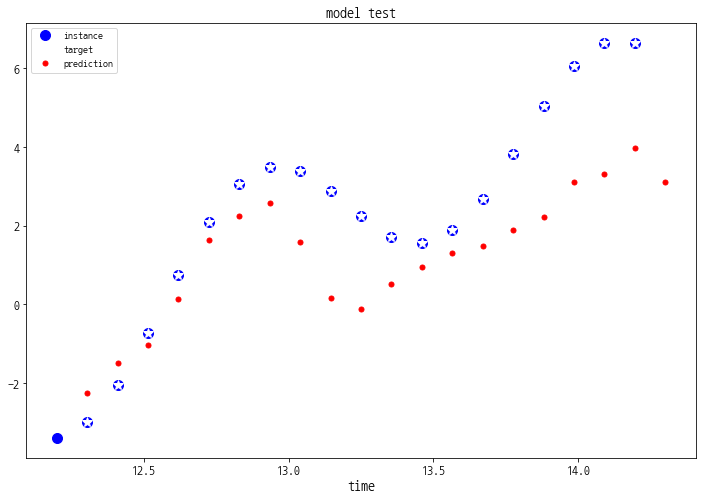

In [86]:
plt.figure(figsize=(12, 8))
plt.title("model test", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("time")

plt.show()

# LSTM

In [ ]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [ ]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [ ]:
states

In [ ]:
top_layer_h_state

In [ ]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("에포크", epoch, "배치 데이터 정확도 =", acc_batch, "검증 세트 정확도 =", acc_valid)
    
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("테스트 세트 정확도 =", acc_test)

In [ ]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

In [ ]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

# 임베딩

이 섹션은 텐서플로의 [Word2Vec 튜토리얼](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html)을 기반으로 합니다.

## 데이터 추출

In [ ]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """디렉토리 생성, 이미 있다면 그냥 통과
    
    이 함수는 파이썬 2 버전을 지원하기 위해서입니다.
    파이썬 3.2 이상이면 다음과 같이 쓸 수 있습니다:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [ ]:
words = fetch_words_data()

In [ ]:
words[:5]

## 사전 구축

In [ ]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [ ]:
" ".join(words[:9]), data[:9]

In [ ]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

In [ ]:
words[24], data[24]

## 배치 생성

In [ ]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # buffer 중간에 타깃 레이블을 둡니다
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [ ]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [ ]:
batch, [vocabulary[word] for word in batch]

In [ ]:
labels, [vocabulary[word] for word in labels[:, 0]]

## 모델 구성

In [ ]:
batch_size = 128
embedding_size = 128  # 임베딩 벡터 차원
skip_window = 1       # 고려할 왼쪽과 오른쪽 단어의 개수
num_skips = 2         # 레이블을 생성하기 위한 입력의 재사용 횟수

# 가까운 이웃을 샘플링하기 위해 랜덤한 검증 세트를 만듭니다.
# 검증 샘플은 가장 흔한 단어인 낮은 ID 번호를 가진 것으로 제한합니다.
valid_size = 16     # 유사도를 평가하기 위해 랜덤하게 구성할 단어 세트 크기
valid_window = 100  # 검증 샘플을 전체 샘플의 앞 부분에서만 선택합니다
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # 부정 샘플링(negative sampling)의 수

learning_rate = 0.01

In [ ]:
reset_graph()

# 입력 데이터
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [ ]:
vocabulary_size = 50000
embedding_size = 150

# 입력을 위해 임베딩을 조회합니다
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [ ]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [ ]:
# NCE 손실을 위한 변수를 만듭니다
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# 배치에서 NCE 손실의 평균을 계산합니다.Compute the average NCE loss for the batch.
# tf.nce_loss는 자동으로 손실을 평가할 때마다 음성 레이블에서 새로운 샘플을 뽑습니다.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Adam 옵티마이저
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# 미니배치 샘플과 모든 임베딩 사이의 코사인 유사도를 계산합니다
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# 초기화를 위한 연산
init = tf.global_variables_initializer()

## 모델 훈련

In [ ]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\r반복: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # 훈련 연산을 평가하여 스텝을 한 단계를 업데이트합니다(session.run()에서 반환된 값을 사용합니다)
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # 평균 손실은 2000개 배치에 대한 손실의 추정입니다.
            print("스텝 ", step, "에서의 평균 손실: ", average_loss)
            average_loss = 0

        # 이 코드는 비용이 많이 듭니다 (500 스텝마다 ~20%씩 느려집니다)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # 가장 가까운 단어의 개수
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "%s에 가장 가까운 단어:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

마지막 임베딩을 저장합니다(물론 텐서플로의 `Saver`를 사용해도 됩니다):

In [ ]:
np.save("./my_final_embeddings.npy", final_embeddings)

## 임베딩 그래프

In [ ]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "임베딩보다 레이블이 많습니다."
    plt.figure(figsize=(18, 18))  # 인치 크기
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# 기계 번역

`basic_rnn_seq2seq()` 함수는 간단한 인코더/디코더 모델을 만듭니다. 먼저 `encoder_inputs`를 상태 벡터로 인코딩하는 RNN을 실행하고 그다음 `decoder_inputs`을 마지막 인코더 상태로 초기화시킨 디코더를 실행합니다. 인코더와 디코더는 같은 RNN 셀 타입을 사용하지만 파라미터를 공유하지는 않습니다.

In [ ]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # 영어 문장
Y = tf.placeholder(tf.int32, [None, n_steps]) # 프랑스어 번역
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # 1D 텐서의 리스트
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # 1D 텐서의 리스트

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [ ]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# 연습문제 해답

## 1. to 6.

부록 A 참조.

## 7. 임베딩된 레버(Reber) 문법

먼저 문법에 맞는 문자열을 생성하는 함수가 필요합니다. 이 문법은 각 상태에서 가능한 전이 상태의 리스트입니다. 하나의 전이는 출력할 문자열(또는 생성할 문법)과 다음 상태를 지정합니다.

In [ ]:
from random import choice, seed

# 일관된 출력을 위한 유사난수 초기화
seed(42)
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (상태 0) =B=>(상태 1)
    [("T", 2), ("P", 3)], # (상태 1) =T=>(상태 2) or =P=>(상태 3)
    [("S", 2), ("X", 4)], # (상태 2) =S=>(상태 2) or =X=>(상태 4)
    [("T", 3), ("V", 5)], # 등등..
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (상태 6) =E=>(종료 상태)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        production, state = choice(grammar[state])
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

기본 레버 문법에 맞는 문자열을 몇 개 만들어 보겠습니다:

In [ ]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

좋습니다. 이제 임베딩된 레버 문법에 맞는 문자열을 몇 개 만들어 보겠습니다:

In [ ]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

좋네요, 이제 이 문법을 따르지 않는 문자열을 생성할 함수를 만듭니다. 무작위하게 문자열을 만들 수 있지만 그렇게 하면 너무 문제가 쉬워지므로 대신 문법을 따르는 문자열을 만든 후 하나의 문자만 바꾸어 놓도록 하겠습니다:

In [ ]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = choice(list(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

잘못된 문자열 몇 개를 만들어 보죠:

In [ ]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

문자열을 바로 RNN에 주입할 수는 없습니다. 먼저 벡터의 연속으로 바꾸어야 합니다. 각 벡터는 원-핫 인코딩을 사용하여 하나의 문자를 나타냅니다. 예를 들어, 벡터 `[1, 0, 0, 0, 0, 0, 0]`는 문자 "B"를 나타내고 벡터 `[0, 1, 0, 0, 0, 0, 0]`는 문자 "E"를 나타내는 식입니다. 이런 원-핫 벡터의 연속으로 문자열을 바꾸는 함수를 작성해 보겠습니다. 문자열이 `n_steps`보다 짧으면 0 벡터로 패딩됩니다(나중에, 텐서플로에게 각 문자열의 실제 길이를 `sequence_length` 매개변수로 전달할 것입니다).

In [ ]:
def string_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    char_to_index = {char: index for index, char in enumerate(chars)}
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for index, char in enumerate(string):
        output[index, char_to_index[char]] = 1.
    return output

In [ ]:
string_to_one_hot_vectors("BTBTXSETE", 12)

이제 50%는 올바른 문자열 50%는 잘못된 문자열로 이루어진 데이터셋을 만듭니다:

In [ ]:
def generate_dataset(size):
    good_strings = [generate_string(embedded_reber_grammar)
                    for _ in range(size // 2)]
    bad_strings = [generate_corrupted_string(embedded_reber_grammar)
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    n_steps = max([len(string) for string in all_strings])
    X = np.array([string_to_one_hot_vectors(string, n_steps)
                  for string in all_strings])
    seq_length = np.array([len(string) for string in all_strings])
    y = np.array([[1] for _ in range(len(good_strings))] +
                 [[0] for _ in range(len(bad_strings))])
    rnd_idx = np.random.permutation(size)
    return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]

In [ ]:
X_train, l_train, y_train = generate_dataset(10000)

첫 번째 훈련 샘플을 확인해 보겠습니다:

In [ ]:
X_train[0]

데이터셋에서 가장 긴 문자열 때문에 패딩된 0 벡터가 많습니다. 문자열 길이가 얼마나 될까요?

In [ ]:
l_train[0]

타깃 클래스는?

In [ ]:
y_train[0]

아주 좋습니다! 올바른 문자열을 구분할 RNN을 만들 준비가 되었습니다. 앞서 MNIST 이미지를 분류하기 위해 만든 것과 매우 비슷한 시퀀스 분류기를 만듭니다. 차이점은 다음 두 가지입니다:
* 첫째, 입력 문자열이 가변 길이이므로 `dynamic_rnn()` 함수를 호출할 때 `sequence_length`를 지정해야 합니다.
* 둘째, 이진 분류기이므로 출력 뉴런은 하나만 필요합니다. 이 뉴런은 각 문자열에 대해 올바른 문자열일 추정 로그 확률을 출력할 것입니다. 다중 클래스 분류에서는 `sparse_softmax_cross_entropy_with_logits()`를 사용했지만 이진 분류에서는 `sigmoid_cross_entropy_with_logits()`를 사용합니다.

In [ ]:
reset_graph()

possible_chars = "BEPSTVX"
n_inputs = len(possible_chars)
n_neurons = 30
n_outputs = 1

learning_rate = 0.02
momentum = 0.95

X = tf.placeholder(tf.float32, [None, None, n_inputs], name="X")
seq_length = tf.placeholder(tf.int32, [None], name="seq_length")
y = tf.placeholder(tf.float32, [None, 1], name="y")

gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

logits = tf.layers.dense(states, n_outputs, name="logits")
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_pred")
y_proba = tf.nn.sigmoid(logits, name="y_proba")

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=momentum,
                                       use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.equal(y_pred, y, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

훈련하는 동안 진척 상황을 확인할 수 있도록 검증 세트를 만듭니다:

In [ ]:
X_val, l_val, y_val = generate_dataset(5000)

In [ ]:
n_epochs = 50
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run(
                [loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:4d}  훈련 손실: {:.4f}, 정확도: {:.2f}%  검증 세트 정확도: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
        saver.save(sess, "./my_reber_classifier")

이제 두 개의 문자열에 이 RNN을 테스트해 보죠. 첫 번째는 잘못된 것이고 두 번째는 올바른 것입니다. 이 문자열은 마지막에서 두 번째 글자만 다릅니다. RNN이 이를 맞춘다면 두 번째 문자가 항상 끝에서 두 번째 문자와 같아야 한다는 패턴을 알게 됐다는 것을 의미합니다. 이렇게 하려면 꽤 긴 단기 기억(long short-term memory)이 필요합니다(그래서 GRU 셀을 사용했습니다).

In [ ]:
test_strings = [
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVETE",
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVEPE"]
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [string_to_one_hot_vectors(s, n_steps=max_length)
          for s in test_strings]

with tf.Session() as sess:
    saver.restore(sess, "./my_reber_classifier")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})

print()
print("레버 문자열일 추정 확률:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba_val[index][0]))

쨘! 잘 작동하네요. 이 RNN이 완벽한 신뢰도로 정확한 답을 냈습니다. :)

## 8. 과 9.

Coming soon...